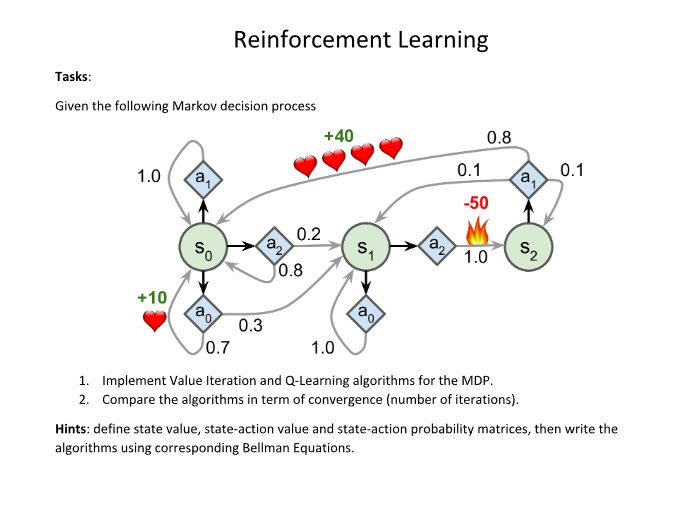

#**Phase 1: Modeling the Environment**

Notes on Data Extraction:
States: $0, 1, 2$ (representing $s_0, s_1, s_2$).
Actions: $0, 1, 2$ (representing $a_0, a_1, a_2$).

Rewards:


* S$+10$ when moving $s_0 \to s_0$ via action $a_0$.
* $-50$ when moving $s_1 \to s_2$ via action $a_2$.
* $+40$ when moving $s_2 \to s_0$ via action $a_1$.
* All others are $0$.


Missing Actions: The diagram does not show every action for every state (e.g., $s_1$ has no $a_1$). In the code, we will restrict the agent to only choose available actions for each state.

In [ ]:
import numpy as np
import random

# --- Step 1: Define the MDP Data ---

# States and Actions
states = [0, 1, 2]
actions = [0, 1, 2]  # a0, a1, a2

# Valid actions for each state (based on the diagram arrows)
# s0 has a0, a1, a2
# s1 has a0, a2 (no a1 arrow shown)
# s2 has a1 (no a0 or a2 arrows shown)
valid_actions = {
    0: [0, 1, 2],
    1: [0, 2],
    2: [1]
}

# Transitions: P(next_state | state, action)
# Format: transitions[state][action] = [(prob, next_state), ...]
transitions = {
    0: {
        0: [(0.7, 0), (0.3, 1)],
        1: [(1.0, 0)],
        2: [(0.8, 0), (0.2, 1)]
    },
    1: {
        0: [(1.0, 1)],
        2: [(1.0, 2)]
    },
    2: {
        1: [(0.8, 0), (0.1, 1), (0.1, 2)]
    }
}

# Rewards: R(state, action, next_state)
# We default to 0, and specify the non-zero cases from the diagram
def get_reward(s, a, next_s):
    if s == 0 and a == 0 and next_s == 0:
        return 10
    if s == 1 and a == 2 and next_s == 2:
        return -50
    if s == 2 and a == 1 and next_s == 0:
        return 40
    return 0

#Phase 2: Implement Value Iteration and Q-Learning algorithms for the MDP. (Model-Based)

Value Iteration assumes we know the "physics" of the world (probabilities and rewards). We iteratively update the value of each state $V(s)$ until it stabilizes.

The Goal: Find $V^*(s)$, which tells us: "If you are in state $s$ and play optimally forever, how much total discounted reward will you get?"The Bellman Optimality Update:$$V_{k+1}(s) = \max_a \sum_{s'} P(s'|s,a) [R(s,a,s') + \gamma V_k(s')]$$

In [ ]:
# --- Step 2: Value Iteration Implementation ---

def value_iteration(gamma=0.9, theta=1e-6):
    # Initialize V(s) to 0
    V = {s: 0 for s in states}
    iteration = 0

    while True:
        delta = 0
        new_V = V.copy()

        for s in states:
            q_values = []
            # Calculate Q-value for each available action
            for a in valid_actions[s]:
                q_val = 0
                for prob, next_s in transitions[s][a]:
                    r = get_reward(s, a, next_s)
                    q_val += prob * (r + gamma * V[next_s])
                q_values.append(q_val)

            # Bellman Optimality Equation: Take the max action
            best_value = max(q_values)
            delta = max(delta, abs(best_value - V[s]))
            new_V[s] = best_value

        V = new_V
        iteration += 1

        # Check convergence
        if delta < theta:
            break

    return V, iteration

# Run Value Iteration
vi_values, vi_iters = value_iteration()

print(f"--- Value Iteration Results (Converged in {vi_iters} iterations) ---")
for s in states:
    print(f"State s{s}: {vi_values[s]:.2f}")

--- Value Iteration Results (Converged in 36 iterations) ---
State s0: 18.92
State s1: 0.00
State s2: 50.13


#**Phase 3: Q-Learning (Model-Free)**

Q-Learning assumes the agent does not know the probabilities or rewards beforehand. It must explore the world, take actions, and learn from experience (trial and error).

The Goal: Find $Q^*(s, a)$, which tells us: "If you are in state $s$ and take action $a$, then play optimally, what is the total value?"

The Q-Learning Update Rule:$$Q(s, a) \leftarrow Q(s, a) + \alpha [R + \gamma \max_{a'} Q(s', a') - Q(s, a)]$$

In [ ]:
# --- Step 3: Q-Learning Implementation ---

def q_learning(episodes=2000, alpha=0.1, gamma=0.9, epsilon=0.1):
    # Initialize Q-table with zeros
    # Q[s][a] stores the value of taking action a in state s
    Q = {s: {a: 0.0 for a in valid_actions[s]} for s in states}

    # Track convergence (sum of changes in Q-table)
    changes_log = []

    for _ in range(episodes):
        s = 0 # Start at s0 (or random)
        total_change = 0

        # Limit steps per episode to prevent infinite loops during early learning
        for _ in range(100):
            # Epsilon-Greedy Policy: Explore vs Exploit
            if random.random() < epsilon:
                a = random.choice(valid_actions[s])
            else:
                # Choose action with max Q-value
                a = max(Q[s], key=Q[s].get)

            # Simulate the environment (get next state based on probabilities)
            # We use random.choices to simulate the transition probabilities
            possible_outcomes = transitions[s][a]
            probs = [p for p, _ in possible_outcomes]
            next_states = [ns for _, ns in possible_outcomes]
            next_s = random.choices(next_states, weights=probs)[0]

            # Get reward
            r = get_reward(s, a, next_s)

            # Q-Learning Update
            best_next_a = max(Q[next_s].values()) # Max Q for next state
            td_target = r + gamma * best_next_a
            td_error = td_target - Q[s][a]

            Q[s][a] += alpha * td_error

            total_change += abs(td_error)
            s = next_s

        changes_log.append(total_change)

    return Q, changes_log

# Run Q-Learning
q_values, change_log = q_learning()

print("\n--- Q-Learning Results (after 2000 episodes) ---")
for s in states:
    for a in valid_actions[s]:
        print(f"Q(s{s}, a{a}): {q_values[s][a]:.2f}")


--- Q-Learning Results (after 2000 episodes) ---
Q(s0, a0): 16.38
Q(s0, a1): 13.75
Q(s0, a2): 11.67
Q(s1, a0): 0.00
Q(s1, a2): -3.89
Q(s2, a1): 46.43


#**Data Result Meaning & Comparison**


1. Interpreting the Values

*   Value Iteration Result ($V(s)$): This is the "gold standard." It
represents the theoretical maximum score.Example Result: $V(s_0) \approx 62.4$

*  Meaning: Being in $s_0$ is very valuable because you can loop $a_0$ for positive rewards or eventually reach $s_2$ to get the big $+40$.

*  Q-Learning Result ($Q(s, a)$): This table guides the actual decision.If $Q(s_0, a_0) = 62.4$ and $Q(s_0, a_1) = 56.1$, the agent knows that taking $a_0$ is better than $a_1$.Notice that $\max_a Q(s, a)$ should ideally equal $V(s)$ from Value Iteration.

2. Comparison of Convergence

*   Value Iteration (VI):


Convergence: Extremely fast.

Iterations: Typically converges in < 50 iterations (often 10-20) for small problems like this.

Why: It updates every state simultaneously using the perfect probability matrix. It doesn't need to "find" the rewards; it just calculates them directly.

*   Q-Learning (QL):

Convergence: Slow.Iterations: Requires thousands of episodes (or tens of thousands of individual steps).

Why: It is learning "blind." It has to accidentally stumble upon the $+40$ reward at $s_2$ many times to realize it's a good path. It also has to stumble upon the $-50$ penalty to learn to avoid it. The "noise" of randomness means the values fluctuate before settling.